<h1>Simple Guide to Machine Learning Model Interpretation</h1>
<p>This is a guide to interpreting machine learning models, the main objective of this notebook is to familiarize ourselves with the major state-of-the-art model interpretation frameworks out there.
<br><br>
The major model interpreation techniques that are going to be implemented are:
<br>
<ul>
    <b>
        <li>Feature Importances</li>
    <li>Partial Dependence Plots</li>
    <li>Model Prediction Explanations with Local Interpretation</li>
    <li>Building Interpretable Models with Surrogate Tree-based Models</li>
    <li>Model Prediction Explanation with SHAP values</li>
    <li>Dependence & Interaction Plots with SHAP</li>
    </b>
</ul>
</p>

<h2>Loading Necessary Dependencies</h2>
<p>
    For this notebook and its aim for explaining model interprations some frameworks and tools will be used, due this the next dependencies must be loaded.
</p>

In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import shap
import eli5
import xgboost as xgb

from skater.core.explanations import Interpretation
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.model import InMemoryModel
from sklearn.model_selection import train_test_split
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG
from collections import Counter

import os
# This is for Windows 10 users
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

C:\Users\kleye\Anaconda3\envs\ai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html
Using TensorFlow backend.


<p>The <code>shap.initjs()</code> function is called since a lot of the plots from shap require JavaScript.</p>

<h2>Load and View the Census Income Dataset</h2>
<p>
    The dataset can be download from here <a href='https://archive.ics.uci.edu/ml/datasets/adult'>UCI ML Repository</a>. Fortunately <code>shap</code> provides an already cleaned up version of this dataset which will be using here since the intent of this notebook is model interpration.
</p>

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print('The shape of the dataset is: {}\nThe shape of the labels is: {}'.format(data.shape, labels.shape))
data.sample(10)

The shape of the dataset is: (32561, 12)
The shape of the labels is: (32561,)


Age Workclass  Education-Num          Marital Status  \
11279  38.0   Private           13.0                Divorced   
29198  59.0   Private           11.0      Married-civ-spouse   
32312  34.0   Private            8.0   Married-spouse-absent   
11663  64.0   Private            7.0                 Widowed   
28475  57.0   Private           13.0      Married-civ-spouse   
18761  41.0   Private           10.0                Divorced   
25596  28.0   Private            9.0      Married-civ-spouse   
8063   23.0   Private            4.0           Never-married   
28739  36.0   Private            7.0      Married-civ-spouse   
21509  37.0   Private            2.0           Never-married   

               Occupation    Relationship                 Race      Sex  \
11279        Adm-clerical       Unmarried   Asian-Pac-Islander   Female   
29198               Sales         Husband                White     Male   
32312   Handlers-cleaners       Unmarried                White     Male   
11663     Farming-fishing       Unmarried                White   Female   
28475     Exec-managerial         Husband                White     Male   
18761        Craft-repair   Not-in-family                White   Female   
25596        Craft-repair         Husband                White     Male   
8063        Other-service       Own-child                White     Male   
28739   Machine-op-inspct         Husband                White     Male   
21509       Other-service   Not-in-family                White     Male   

       Capital Gain  Capital Loss  Hours per week         Country  
11279           0.0         213.0            40.0     Philippines  
29198           0.0        1740.0            50.0   United-States  
32312           0.0           0.0            35.0          Mexico  
11663           0.0           0.0            40.0   United-States  
28475           0.0           0.0            40.0   United-States  
18761           0.0           0.0            50.0   United-States  
25596           0.0           0.0            35.0   United-States  
8063            0.0           0.0            35.0   United-States  
28739           0.0           0.0            40.0   United-States  
21509           0.0           0.0            40.0   United-States

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


In [4]:
data.describe()

Age  Education-Num  Capital Gain  Capital Loss  Hours per week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581646      10.080679   1077.648804     87.303833       40.437454
std       13.640432       2.572720   7385.291992    402.960205       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

<h2>Feature Engineering for Categorical Features</h2>
<p>
    The categorical featuers are going to be converted from string values to numeric representations.
    <br><br>
    The <b>XGBoost</b> model can handle categorical data natively being a tree-based model so there is not need to one-hot encode the features.
</p>

In [5]:
category_cols = data.select_dtypes(['category']).columns
data[category_cols] = data[category_cols].apply(lambda x: x.cat.codes)

In [6]:
data.sample(10)

Age  Workclass  Education-Num  Marital Status  Occupation  \
31907  48.0          4           14.0               2          10   
3837   49.0          4            9.0               0           4   
27624  35.0          4           11.0               0          10   
4581   57.0          4            3.0               0          14   
4117   50.0          4            9.0               4          13   
3941   28.0          4            2.0               2           7   
1124   48.0          4           10.0               0           8   
29828  56.0          6            7.0               2           3   
27157  62.0          6           14.0               0          10   
10633  32.0          4           10.0               2          14   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
31907             0     4    1           0.0           0.0            40.0   
3837              1     4    1           0.0           0.0            40.0   
27624             3     2    1           0.0           0.0            40.0   
4581              4     4    1        6497.0           0.0            40.0   
4117              3     4    1           0.0           0.0            15.0   
3941              0     4    1           0.0           0.0            43.0   
1124              4     2    0           0.0           0.0            35.0   
29828             0     4    1           0.0           0.0            20.0   
27157             4     4    0           0.0           0.0            32.0   
10633             0     4    1           0.0        1485.0            45.0   

       Country  
31907        5  
3837        39  
27624       39  
4581        39  
4117        39  
3941        26  
1124        39  
29828       39  
27157       39  
10633       39

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null int8
Education-Num     32561 non-null float32
Marital Status    32561 non-null int8
Occupation        32561 non-null int8
Relationship      32561 non-null int8
Race              32561 non-null int8
Sex               32561 non-null int8
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null int8
dtypes: float32(5), int8(7)
memory usage: 858.6 KB


In [8]:
data.describe()

Age     Workclass  Education-Num  Marital Status  \
count  32561.000000  32561.000000   32561.000000    32561.000000   
mean      38.581646      3.868892      10.080679        2.611836   
std       13.640432      1.455960       2.572720        1.506222   
min       17.000000      0.000000       1.000000        0.000000   
25%       28.000000      4.000000       9.000000        2.000000   
50%       37.000000      4.000000      10.000000        2.000000   
75%       48.000000      4.000000      12.000000        4.000000   
max       90.000000      8.000000      16.000000        6.000000   

         Occupation  Relationship          Race           Sex  Capital Gain  \
count  32561.000000  32561.000000  32561.000000  32561.000000  32561.000000   
mean       6.572740      1.446362      3.665858      0.669205   1077.648804   
std        4.228857      1.606771      0.848806      0.470506   7385.291992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      0.000000      4.000000      0.000000      0.000000   
50%        7.000000      1.000000      4.000000      1.000000      0.000000   
75%       10.000000      3.000000      4.000000      1.000000      0.000000   
max       14.000000      5.000000      4.000000      1.000000  99999.000000   

       Capital Loss  Hours per week       Country  
count  32561.000000    32561.000000  32561.000000  
mean      87.303833       40.437454     36.718866  
std      402.960205       12.347429      7.823782  
min        0.000000        1.000000      0.000000  
25%        0.000000       40.000000     39.000000  
50%        0.000000       40.000000     39.000000  
75%        0.000000       45.000000     39.000000  
max     4356.000000       99.000000     41.000000

<h2>A look at the Class Labels</h2>
<p>
    Lookig at the distribution of people with an income &lt;=\$50K (<code>False</code>) and &gt;=\$50K (<code>True</code>)
</p>

In [9]:
Counter(labels)

Counter({0: 24720, 1: 7841})

<p>
    There is class imbalanced in the dataset, which is expected given that we should have less people having a higher income.
</p>

<h2>Split the Dataset into a Train and Test Sets</h2>
<p>
    As always the model will be build with the <i>train dataset</i> and its performance is going to be tested on the <i>test dataset</i>.<br><br>
    Two datasets are going to be kept, one with the encoded categorical values and the other one with the original values, the dataset that is going to be used for the training process is the set with the encoded categorical values and the set with the original values is going to be used for the model interpretation.
</p>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print('The shape of the Train Set is: {}\nThe shape of the Test Set is: {}'.format(X_train.shape, X_test.shape))

The shape of the Train Set is: (22792, 12)
The shape of the Test Set is: (9769, 12)


In [11]:
X_train.sample(5)

Age  Workclass  Education-Num  Marital Status  Occupation  \
16534  19.0          4            9.0               4          14   
28767  67.0          6            9.0               2           5   
26106  48.0          4            9.0               2           3   
22427  34.0          4           13.0               2          14   
30555  30.0          6            9.0               2           5   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
16534             3     4    1        2176.0           0.0            45.0   
28767             0     4    1        1797.0           0.0            20.0   
26106             0     4    1           0.0           0.0            40.0   
22427             0     1    1           0.0           0.0            40.0   
30555             0     4    1           0.0           0.0            85.0   

       Country  
16534       39  
28767       39  
26106       39  
22427       39  
30555       39

In [12]:
X_test.sample(5)

Age  Workclass  Education-Num  Marital Status  Occupation  \
2333   35.0          4            7.0               5          14   
31685  60.0          4            9.0               2           1   
24621  64.0          4            9.0               2           3   
21567  39.0          2           12.0               0           8   
7442   24.0          4           12.0               4           3   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
2333              1     4    1           0.0           0.0            90.0   
31685             0     4    1           0.0           0.0            40.0   
24621             0     4    1        2635.0           0.0            40.0   
21567             4     4    0           0.0           0.0            55.0   
7442              1     4    1        2354.0           0.0            40.0   

       Country  
2333        39  
31685       39  
24621       39  
21567       39  
7442        39

<p>
    The original dataset with the categorical values is going to be maintained in a specific dataframe, which is going to be useful for model interpretation later.
</p>

In [13]:
data_modelInterpration, labels_modelInterpration = shap.datasets.adult(display=True)
X_train_modelInterpretation, X_test_modelInterpretation, y_train_modelInterpretation, y_test_modelInterpretation = train_test_split(data_modelInterpration, labels_modelInterpration, test_size=0.30, random_state=42)
print('The shape of the Train Model Interpretation Set is: {}\nThe shape of the Test Model Interpretation Set is: {}'.format(X_train_modelInterpretation.shape, X_test_modelInterpretation.shape))

The shape of the Train Model Interpretation Set is: (22792, 12)
The shape of the Test Model Interpretation Set is: (9769, 12)


In [14]:
X_train_modelInterpretation.sample(5)

Age          Workclass  Education-Num       Marital Status  \
26874  40.0            Private            5.0        Never-married   
1980   53.0          Local-gov           15.0             Divorced   
6180   71.0   Self-emp-not-inc           15.0   Married-civ-spouse   
8507   34.0          Local-gov           10.0             Divorced   
24943  41.0            Private           13.0   Married-civ-spouse   

              Occupation    Relationship    Race      Sex  Capital Gain  \
26874   Transport-moving   Not-in-family   White     Male           0.0   
1980      Prof-specialty   Not-in-family   White   Female           0.0   
6180     Farming-fishing         Husband   White     Male           0.0   
8507        Adm-clerical       Unmarried   White   Female           0.0   
24943              Sales         Husband   White     Male        7688.0   

       Capital Loss  Hours per week         Country  
26874           0.0            45.0   United-States  
1980            0.0            50.0   United-States  
6180            0.0             2.0   United-States  
8507            0.0            35.0   United-States  
24943           0.0            50.0   United-States

In [15]:
X_test_modelInterpretation.sample(5)

Age          Workclass  Education-Num       Marital Status  \
24510  50.0   Self-emp-not-inc           15.0   Married-civ-spouse   
1023   34.0            Private           10.0   Married-civ-spouse   
8478   30.0          State-gov           14.0   Married-civ-spouse   
23825  62.0                  ?            4.0   Married-civ-spouse   
4203   55.0            Private           13.0            Separated   

             Occupation    Relationship                 Race    Sex  \
24510   Exec-managerial         Husband                White   Male   
1023      Other-service         Husband                White   Male   
8478     Prof-specialty         Husband   Asian-Pac-Islander   Male   
23825                 ?         Husband                White   Male   
4203    Exec-managerial   Not-in-family                White   Male   

       Capital Gain  Capital Loss  Hours per week         Country  
24510       99999.0           0.0            50.0   United-States  
1023            0.0           0.0            40.0   United-States  
8478            0.0           0.0            10.0           China  
23825           0.0           0.0            40.0   United-States  
4203        14084.0           0.0            45.0   United-States

<h2>Training the XGBoost Classification Model</h2>
<p>
    Now is time for training and building a basic boosting classification model on the training data using <a href='https://xgboost.readthedocs.io/en/latest/'>XGBoost</a> framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
</p>

In [16]:
%%time

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5, objective='binary:logistic', random_state=42, n_jobs=-1)
xgc.fit(X_train, y_train)

Wall time: 2.77 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

<h2>Predicting on the Test Data</h2>
<p>
    The trained model <code>xgc</code> is going to be used to make predictions on the test dataset.
</p>

In [17]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

<h2>Model Performance Evaluation</h2>
<p>
    Evaluation of how the model has performed with its predictions on the test data, this is going to be done with the <code>model_evaluation_utils</code> module, this modules uses <code>scikit-learn</code> internally to show standard classification model evaluation metrics.
</p>

In [18]:
class_labesl = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labesl)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


<h2>Default Model Interpretation Methods</h2>
<p>
    By default it is difficult to gauge on specific model interpretation methods for machine learning models out of the box. Parametric models like logistic regression are easier to interpret given that the total number of parameters of the model are fixed regardless of the volume of data and one can make some interpretation of the model’s prediction decisions leveraging the parameter coefficients.<br><br>
    Non-parametric models are harder to interpret given that the total number of parameters remain unbounded and increase with the increase in the data volume. Some non-parametric models like tree-based models do have some out of the box model interpretation methods like feature importance which helps us in understanding which features might be influential in the model making its prediction decisions.
</p>
<h3 id='feature_importances'>Feature importances from XGBoost</h3>
<p>
    The global feature importance calculations that comes with XGBoost. The model enables the view of <i>feature importances</i> based on:<br>
    <ul>
        <li><b>Feature Weights:</b> This is based on the number of times a featuer appears in a tree across the ensemble of trees.</li>
        <li><b>Gain:</b> This is based on the average gain of splits which use the feature.</li>
        <li><b>Coverage:</b> This is based on the average coverage ( number of samples affected) of splits which use the feature.</li>
    </ul>
<br>
Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).
</p>

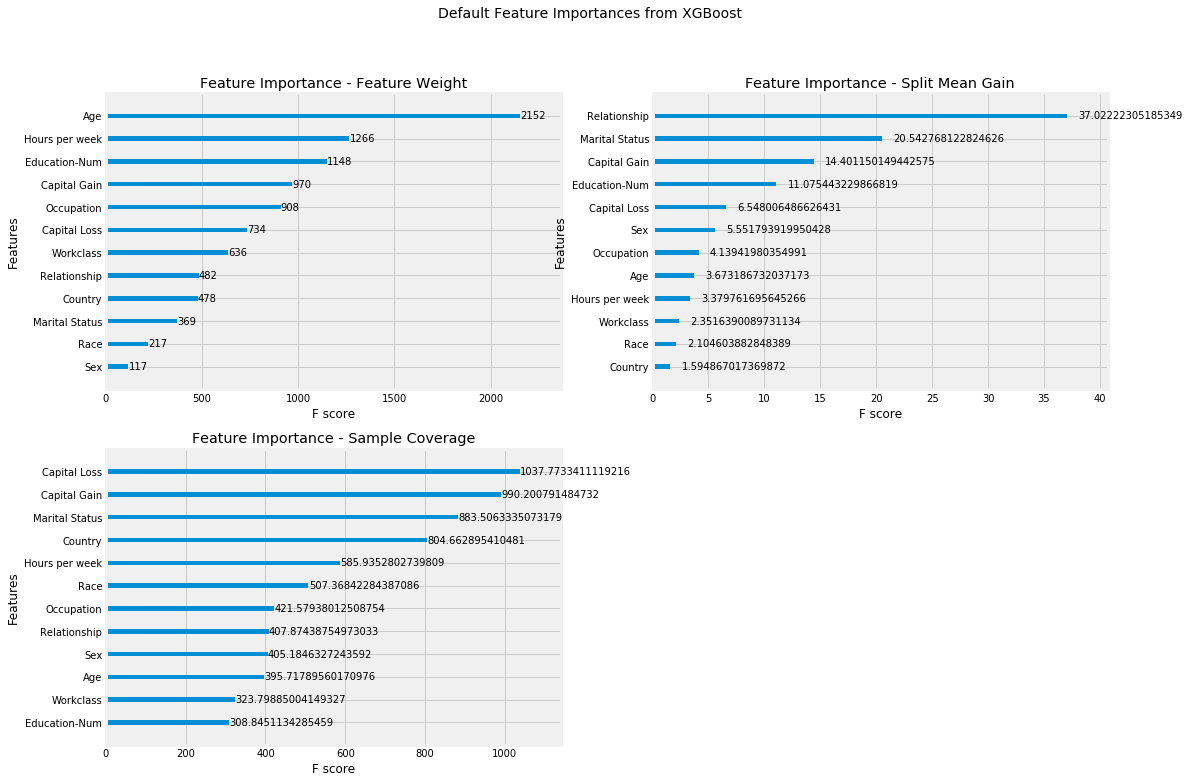

In [19]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

<h2>Model Interpretation with Eli5</h2>
<p>
    <a href='https://github.com/TeamHG-Memex/eli5'>ELI5</a> is a Python package which helps to debug machine learning classifiers and explain their predictions in an easy to understand an intuitive way. It is perhaps the easiest of the three machine learning frameworks to get started with since it involves minimal reading of documentation! <i>However it doesn’t support true model-agnostic interpretations and support for models are mostly limited to tree-based and other parametric\linear models.</i><br> Let’s look at some intuitive ways of model interpretation with ELI5 on our classification model.
<br>
<h3>Feature Importances with ELI5</h3>
<br>
Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, ‘gain’ is used, that is the average gain of the feature when it is used in trees.
</p>


In [20]:
eli5.show_weights(xgc.get_booster())

<h2>Explaining Model Prediction Decisions with ELI5</h2>
<p>
    One of the best way to explain model prediction decisions to either a technical or a more business-oriented individual, is to examine individual data-point predictions.<br><br>
    Typically, ELI5 does this by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. The idea for weight calculation is described <a href='http://blog.datadive.net/interpreting-random-forests/'>here</a>.<br><br>
    ELI5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles which is definitely on the path towards model-agnostic interpretation but not purely model-agnostic like LIME.

Typically, the prediction can be defined as the sum of the feature contributions + the “bias” (i.e. the mean given by the topmost region that covers the entire training set)
</p>
<h3>Predicting when a Person's icome is less or equal than \$50K</h3>
<p>
The most influential featuers are:
<ul>
    <li>Age</li>
    <li>Hours per week</li>
    <li>Marital Status</li>
    <li>Ocuppation</li>
    <li>Relationship</li>
</ul>
</p>

In [21]:
doc_num = 0
print('Actual Label:{}'.format(y_test[doc_num]))
print('Predicted Label: {}'.format(predictions[doc_num]))
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], feature_names=list(data.columns), show_feature_values=True)

Actual Label:0
Predicted Label: 0


<h3>Predicting when a Person's icome is more than \$50K</h3>
<p>
The most influential featuers are:
<ul>
    <li>Education</li>
    <li>Relationship</li>
    <li>Ocuppation</li>
    <li>Hours per week</li>
    <li>Marital Status</li>
</ul>
</p>

In [22]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], feature_names=list(data.columns) ,show_feature_values=True)

Actual Label: 1
Predicted Label: 1


<h2>Model Interpretation with Skater</h2
<br>
<p>
    Skater is a unified framework to enable Model Interpretation for all forms of models to help one build an Interpretable machine learning system often needed for real world use-cases using a model-agnostic approach. It is an open source python library designed to demystify the learned structures of a black box model both globally(inference on the basis of a complete data set) and locally(inference about an individual prediction).
</p>
<img src='images/skater_simple_explanation.png'/>
<p>
<br>
    Skater originally started off as a fork of LIME but then broke out as an independent framework of it's own with a wide variety of feature and capabilities for model-agnostic interpretation for any black-box models. The project was started as a research idea to find ways to enable better interpretability(preferably human interpretability) to predictive "black boxes" both for researchers and practioners.
</p>
<h2>Global Interpretation with Skater</h2>
<p>
    A predictive model is a mapping from an input space to an output space. Interpretation algorithms are divided into those that offer statistics and metrics on regions of the domain, such as the marginal distribution of a feature, or the joint distribution of the entire training set.
    <br><br>
    In an ideal world there would exist some representation that would allow a human to interpret a decision function in any number of dimensions. Given that we generally can only intuit visualizations of a few dimensions at time, global interpretation algorithms either aggregate or subset the feature space.
    <br><br>
    Currently, model-agnostic global interpretation algorithms supported by skater include partial dependence and feature importance with a very new release of tree-surrogates also. Feature importance and partial dependence plots will be cover in this notebook.
</p>
<h3>Creating an interpretation object</h3>
<p>
    The general workflow within the skater package is to create an interpretation, create a model, and run interpretation algorithms.<br><br>
    Typically, an Interpretation consumes a dataset, and optionally some metadata like feature names and row ids. Internally, the Interpretation will generate a DataManager to handle data requests and sampling.
    <br>
    <ul>
        <li><b>Local Models(<code>InMemoryModel</code>):</b> To create a skater model based on a local function or method, pass in the predict function to an <code>InMemoryModel</code>. A user can optionally pass data samples to the examples keyword argument. This is only used to infer output types and formats. Out of the box, skater allows models return numpy arrays and pandas dataframes.</li>
        <li><b>Operationalized Model(<code>DeployedModel</code>):</b> If the model is accessible through an API, <code>DeployedModel</code> must be used, which wraps the requests library. <code>DeployedModel</code> require two functions, an input formatter and an output formatter, which speak to the requests library for posting and parsing. The input formatter takes a pandas DataFrame or a numpy ndarray, and returns an object (such as a dict) that can be converted to JSON to be posted. The output formatter takes a requests.response as an input and returns a numpy ndarray or pandas DataFrame.</li>
    </ul>
    <br>
    The workflow that is going to be implemented is:
    <ul>
        <li>Build an interpretation object.</li>
        <li>Build an in-memory model.</li>
        <li>Perform interpretations</li>
    </ul>
</p>

In [23]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba,
                         examples=X_train,
                         target_names=['$50K or less','More than $50K'])

<h2>Feature Importances with Skater</h2>
<p>
    Feature importance is generic term for the degree to which a predictive model relies on a particular feature. The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model’s decision criteria depend on a feature, the more we’ll see predictions change as a function of perturbing a feature. The default method used is <code>prediction-variance</code> which is the mean absolute value of changes in predictions, given perturbations in the data.
</p>

2019-09-14 20:33:47,913 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 7 seconds

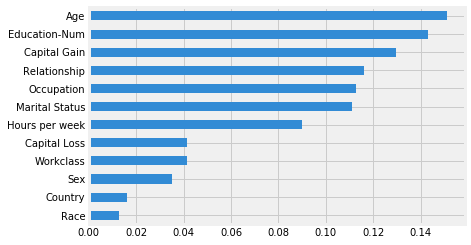

In [24]:
plots = interpreter.feature_importance.plot_feature_importance(im_model,
                                                               ascending=True,
                                                               n_samples=23000, n_jobs=-1)

<h2>Partial Dependence</h2>
<p>
    Partial Dependence describes the marginal impact of a feature on model prediction, holding other features in the model constant. The derivative of partial dependence describes the impact of a feature (analogous to a feature coefficient in a regression model). This has been adapted from T. Hastie, R. Tibshirani and J. Friedman, Elements of Statistical Learning Ed. 2, Springer. 2009.
    <br><br>
    The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. <i>PDPs can show if the relationship between the target and a feature is linear, monotonic or more complex.</i> Skater can show 1-D as well as 2-D PDPs.
</p>
<h3>PDP of 'Age' affecting model prediction</h3>
<p>
    Let's take a look at how the <code>Age</code> feature affects model predictions.
</p>

2019-09-14 20:34:10,766 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 10 seconds

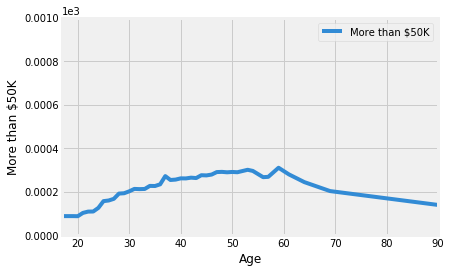

In [25]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'],
                                                           im_model,
                                                           grid_resolution=50,
                                                           grid_range=(0,1),
                                                           n_samples=23000,
                                                           with_variance=True,
                                                           figsize=(6,4), n_jobs=-1)
yl = r[0][1].set_ylim(0, 1)

<p>
    Looks like the middle-aged people have a slightly higher chance of making more money as compared to younger or older people.
</p>
<h3>PDP of 'Education Num' affecting model prediction</h3>
<p>
    Looks like higher the education level, better the chance of making more money, Not surprising!
</p>

2019-09-14 20:34:36,706 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 6 seconds

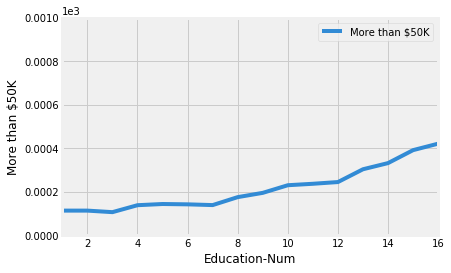

In [26]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'],
                                                           im_model,
                                                           grid_resolution=50, 
                                                           grid_range=(0,1),
                                                           n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4),
                                                           n_jobs=-1)
yl = r[0][1].set_ylim(0, 1)

<h3>PDP of 'Capital Gain' affecting model prediction</h3>
<p>
    Unsurprisingly higher the capital gain, the more chance of making money, there is a steep rise in around \$5K to \$8K
</p>

2019-09-14 20:34:58,763 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 3 seconds

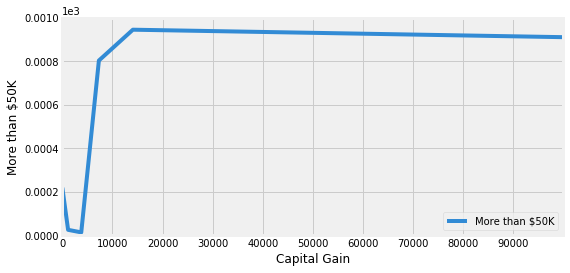

In [27]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'],
                                                           im_model,
                                                           grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True,
                                                           figsize = (8, 4),
                                                           n_samples=23000,
                                                           n_jobs=-1)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

<h3>PDP of 'Relationship' affecting model prediction</h3>
<p>
    Remember that relationship is coded as a categorical variable with numeric representations. Let's first look at how it is represented.
</p>

In [28]:
pd.concat([data_modelInterpration[['Relationship']],
           data[['Relationship']]],
          axis=1).drop_duplicates()

Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2

2019-09-14 20:35:17,171 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 3 seconds

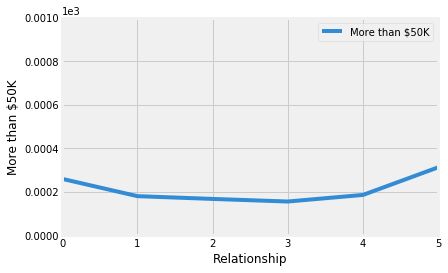

In [29]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'],
                                                           im_model,
                                                           grid_resolution=50, 
                                                           grid_range=(0,1),
                                                           n_samples=23000, 
                                                           with_variance=True,
                                                           figsize = (6, 4),
                                                           n_jobs=-1)
yl = r[0][1].set_ylim(0, 1)

<p


<p>
    Interesting definitely that married folks (husband-wife) have a higher chance of making more money than others!
</p>
<h3>Two-way PDP showing interactions between features 'Age' and 'Education-Num' and their effect on making more than \$50K</h3>
<p>
A deeper model interpretation here over all the data samples, trying to see interactions between Age and Education-Num and also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.
</p>

2019-09-14 20:35:35,595 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1136/1136] grid cells ████████████████████ Time elapsed: 221 seconds

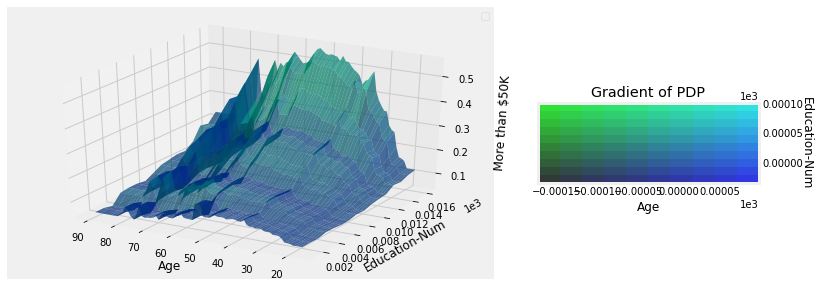

In [30]:

plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1),
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100,
                                                                    n_jobs=-1)

<p>
    Interesting to see higher the education level and the middle-aged folks (30-50) having the highest chance of making more money!
</p>

<h3>Two-way PDP showing interactions between features 'Education-Num' and 'Capital Gain' and their effect on making more than \$50K</h3>
<p>
    A deeper model interpretation here over all the data samples, trying to see interactions between 'Education-Num' and 'Capital Gainand' also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.
</p>

2019-09-14 20:39:33,728 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[160/160] grid cells ████████████████████ Time elapsed: 36 seconds

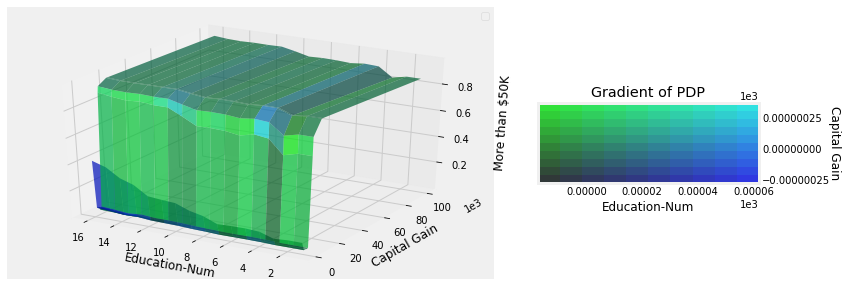

In [31]:

plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')],
                                                                    im_model,
                                                                    grid_range=(0,1),
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100,
                                                                    n_jobs=-1)

<p>
    Basically having a better education and more capital gain leads to you making more money!
</p>

<h3>Local Interpretations with Skater</h3>
<p>
    Local Interpretation could be possibly be achieved in two ways.
    <br>
    <ul>
        <li><b>Firstly:</b> One could possibly approximate the
            behaviorof a complex predictive model in the 
            vicinity of a single input using a simple 
            interpretable auxiliary or surrogate model (e.g. 
            Linear Regressor).</li>
        <li><b>Secondly:</b> One could use the base estimator to
            understand the behavior of a single prediction using
            intuitive approximate functions based on inputs and
            outputs.</li>
    </ul>   
</p>
<h3>Local Interpretable Model-Agnostic Explanations(LIME)</h3>
<p>
    LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator(model) using interpretable surrogate models (e.g. linear classifier/regressor). Such form of comprehensive evaluation helps in generating explanations which are locally faithful but may not align with the global behavior. Basically, LIME explanations are based on local surrogate models. These, surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.
    <br><br>
    The idea is very intuitive. <i>To start with, just try and unlearn what you have done so far!</i> Forget about the training data, forget about how your model works! Think that your model is a black box model with some magic happening inside, where you can input data points and get the models predicted outcomes. You can probe this magic black box as often as you want with inputs and get output predictions.
    <br><br>
    Now, you main objective is to understand why the machine learning model which it is treating as a magic black box, gave the outcome it produced. LIME tries to do this! It tests out what happens to the black box model's predictions when it is fed variations or perturbations of the dataset into the black box model. Typically, LIME generates a new dataset consisting of perturbed samples and the associated black box model's predictions. On this dataset LIME then trains an interpretable model weighted by the proximity of the sampled instances to the instance of interest. Following is a standard high-level workflow for this.
    <br>
    <ul>
        <li>Choose the instance of interest for which it is
            wanted to have an explanation of the predictions of
            the black box model.</li>
        <li>Perturb the dataset and get the black box 
            predictions for these new points.</li>
        <li>Weight the new samples by their proximity to the 
            instance of interest.</li>
        <li>Fit a weighted, interpretable (surrogate) model on 
            the dataset with the variations.</li>
        <li>Explain prediction by interpreting the local 
            model.</li>
    </ul>
    <br>
    <b>Note:</b> It is recommended to read the <a href='https://christophm.github.io/interpretable-ml-book/lime.html'>LIME chapter</a> in 
    Christoph Molnar's excellent book on Model Interpretation 
    which talks about this in detail.
</p>
<h3>Explaining Model Predictions with Skater using LIME</h3>
<p>
    Skater can leverage LIME to explain model predictions. Typically, its <code>LimeTabularExplainer</code> class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. The <code>explain_instance()</code> function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. Then is possible to learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.
    <br><br>
    Since <code>XGBoost</code> has some issues with feature name ordering when building models with dataframes, we will build the same model with numpy arrays to make LIME work without additional hassles of feature re-ordering. Remember the model being built is the same ensemble model which we treat as our black box machine learning model
</p>

In [32]:
xgc_np = xgb.XGBClassifier(n_estimators=500,
                           max_depth=5,
                           base_score=0.5,
                           objective='binary:logistic',
                           random_state=42,
                          n_jobs=-1)

xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [33]:
exp = LimeTabularExplainer(X_test.values,
                           feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

<h3>Predicting when a person's income is &lt;=\$50K</h3>
<p>
    Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K.
</p>

In [34]:

doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 0
Predicted Label: 0


<h3>Predicting when a person's income is &gt; \$50K</h3>
<p>
    Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person’s income as above \$50K.
</p>

In [35]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


<h3>Path to more interpretable models with Tree Surrogates using Skater</h3>
<br>
<p>
    We have see various ways to interpret machine learning models with features, dependence plots and even LIME. But can we build an approximation or a surrogate model which is more interpretable from a really complex black box model like our XGBoost model having hundreds of decision trees?
    <br><br>
    Here in, we introduce the novel idea of using <code>TreeSurrogates</code> as means for explaining a model's learned decision policies (for inductive learning tasks), which is inspired by the work of Mark W. Craven described as the TREPAN algorithm.
    <br><br>
    It is recommended checking out the following excellent papers on the TREPAN algorithm to build surrogate trees:
    <ul>
        <li><a href='http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf'>Extracting Comprehensible Models From Trained Neural Networks</a></li>
        <li><a href='https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf'>Extracting Thee-Structured Representations of Thained Networks</a></li>
    </ul>
    <br>
    Briefly, Trepan constructs a decision tree in a best-first manner. It maintains a queue of leaves which are expanded into subtrees as they are removed from the queue. With each node in the queue, Trepan stores:
    <ul>
        <li>A subset of the training examples.</li>
        <li>Another set of instances (query instances).</li>
        <li>A set of constraints.</li>
    </ul>
    <br>
    The stored subset of training examples consists simply of those examples that reach the node. The query instances are used, along with the training examples, to select the splitting test if the node is an internal node or to determine the class label if it is a leaf. The constraint set describes the conditions that instances must satisfy in order to reach the node; this information is used when drawing a set of query instances for a newly created node. The process of expanding a node in Trepan is much like it is in conventional decision tree algorithms: a splitting test is selected for the node, and a child is created for each outcome of the test. Each child is either made a leaf of the tree or put into the queue for future expansion.
    <br><br>
    For Skater’s implementation, for building explainable surrogate models, the base estimator(Oracle) could be any form of a supervised learning predictive model — the black box model. The explanations are approximated using Decision Trees(both for Classification/Regression) by learning decision boundaries similar to that learned by the Oracle (predictions from the base model are used for learning the Decision Tree representation). The implementation also generates a fidelity score to quantify tree based surrogate model’s approximation to the Oracle. Ideally, the score should be 0 for truthful explanation both globally and locally. Let’s check this out in action!
</p>
<h3>Using the interpreter instance invoke call to the <code>TreeSurrogate</code></h3>
<p>By using the Interpretation object that was instantiated earlier to invoke a call to the <code>TreeSurrogate</code> capability.</p>

In [36]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)


<h3>Using the surrogate model to learn the decision boundaries learned by the base estimator</h3>
<p>
    <ul>
        <li>Reports the fidelity value when compared to the base 
            estimator (closer to 0 is better)</li>
        <li>Learner uses F1 score as the default metric of 
            choice for classification.</li>
    </ul>
</p>

In [37]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2019-09-14 20:40:15,885 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2019-09-14 20:40:15,886 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2019-09-14 20:40:17,030 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2019-09-14 20:40:17,041 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.889; oracle score 0.898


0.009

<h3>Taking a look at the position for each feature</h3>
<p>
    <ul>
        <li>We do this since the feature names in the surrogate 
            tree are not displayed (but are present in the
            model)</li>
    </ul>
</p>

In [38]:
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(data.columns)]).T

0          1              2               3           4             5   \
0   X0         X1             X2              X3          X4            X5   
1  Age  Workclass  Education-Num  Marital Status  Occupation  Relationship   

     6    7             8             9               10       11  
0    X6   X7            X8            X9             X10      X11  
1  Race  Sex  Capital Gain  Capital Loss  Hours per week  Country

<h3>Visualizing the Surrogate Tree</h3>


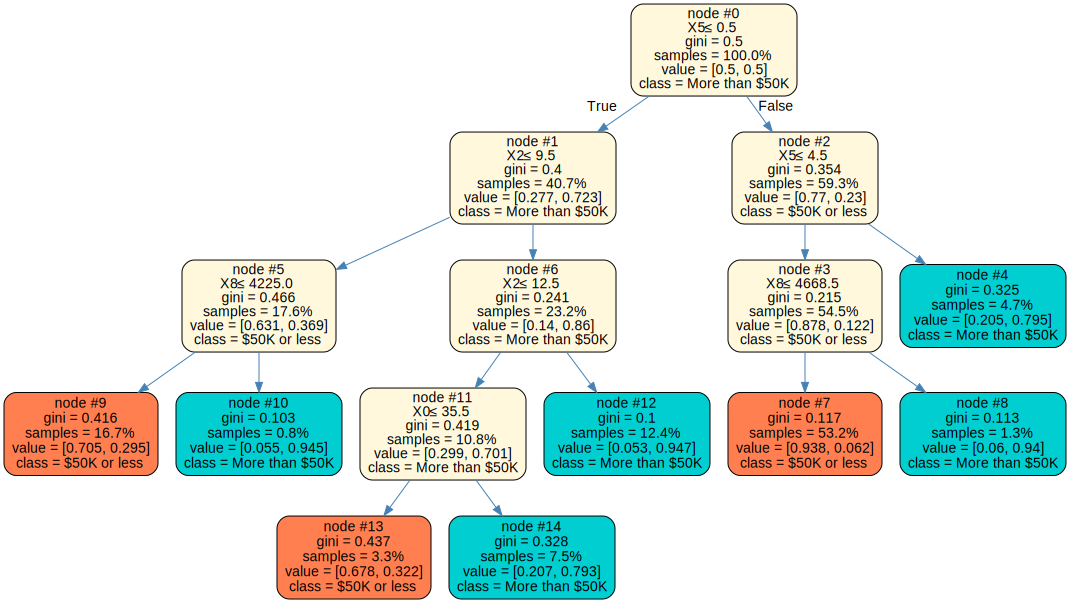

In [39]:
graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

<h3>Interesting rules from the Surrogate Tree</h3>
<p>
    Here are some interesting rules you can observe from the above tree:
    <ul>
        <li>if <code>Relationship</code> &lt; 0.5 (means 0) and <code>Education-num</code> &lt;= 9.5 and <code>Capital Gain</code> &lt;= 4225 &rarr; 70% chance of person making &lt;=  \$50K.</li>
        <li>if <code>Relationship</code> &lt; 0.5 (means 0) and <code>Education-num</code> &lt;= 9.5 and <code>Capital Gain</code> &gt;= 4225 &rarr; 94.5% chance of person making &gt;  \$50K.</li>
        <li>if <code>Relationship</code> &lt; 0.5 (means 0) and <code>Education-num</code> &gt;= 9.5 and <code>Education-num</code> is also &gt;= 12.5 &rarr; 94.7% chance of person making &gt;  \$50K.</li>
    </ul>
    <br>
    Feel free to derive more interesting rules from this and also your own models.
    <br>
    <h3>Surrogate Model Performance Evaluation</h3>
</p>

In [40]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=surrogate_predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8273
Precision: 0.8333
Recall: 0.8273
F1 Score: 0.8299

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      7455
           1       0.62      0.68      0.65      2314

   micro avg       0.83      0.83      0.83      9769
   macro avg       0.76      0.78      0.77      9769
weighted avg       0.83      0.83      0.83      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6504   951
        1        736  1578


<p>
    Just as expected, the model performance drops a fair bit but still we get an overall F1 score of 83% as compared to our boosted model's score of 87% which is quite good.
</p>
<br>
<h3>Model Interpretation with SHAP</h3>
<p>
    <b>SHAP (SHapley Additive exPlanations)</b> is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the <a href='http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions'>SHAP NIPS paper</a> for details).
    <br><br>
    The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods (<a href='https://arxiv.org/abs/1802.03888'>Tree SHAP arXiv paper</a>). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models.
    <br><br>
    SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach.
    
</p>
<br>
<h3>Explain Predictions with SHAP</h3>
<p>
    The Tree SHAP implementation integrated into XGBoost to explain the test dataset, it is necessary to remember that there are a variety of explainer methods based on the type of models that are being build, the SHAP estimates the value for a set of samples (test data).
</p>

In [41]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [42]:
pd.DataFrame(shap_values).sample(5)

0         1         2         3         4         5         6   \
8341  0.763925  0.308342  1.219347 -0.540114  0.393404 -0.106455  0.021170   
4868 -1.698747  0.072736  0.151692 -0.837662 -0.662257 -0.345714  0.008798   
6705 -0.059688 -0.038090 -0.951263 -1.537521 -0.876613 -1.002419  0.044348   
4601  0.618558  0.076833 -0.404714  0.401309 -0.211146  0.436517  0.027461   
9416  0.401578  0.136729 -0.455410  0.399334  0.145364  0.435326  0.019734   

            7         8         9         10        11  
8341  0.102376  7.520213 -0.028907  0.522804  0.042670  
4868  0.197025 -0.130173 -0.055456  0.471606  0.004173  
6705  0.072686 -0.138956 -0.055876 -0.887701  0.011200  
4601  0.066350 -0.141120 -0.043335  0.398328  0.030621  
9416  0.072207 -0.139113 -0.049159  0.377521  0.023950

<p>
    This returns a matrix of SHAP values (<code># samples x # features</code>). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as <code>expected_value</code> attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.</p>

In [43]:
print('Expected Value:{}'.format(explainer.expected_value))

Expected Value:-1.3625856637954712


<h3>Predicting when a Person's income is &lt;= \$50K</h3>
<p>
    SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.</p>

In [44]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_modelInterpretation.iloc[0,:])

<h3>Predicting when a person's income is &gt; \$50K</h3>
<p>
Similarly, SHAP values gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as greater than \$50K.
</p>

In [45]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_modelInterpretation.iloc[2,:])

<h3>Visualizing and Explaining Multiple Predictions</h3>
<p>
    One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.</p>

In [46]:

shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_modelInterpretation.iloc[:1000,:])

<p>
    The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.
    <br>
    <ul>
        <li>The first 100 test samples all probably <b>earn more than 
            \$50K</b> and they <b>are married</b> or\and have a <b>good 
            capital gain</b> or\and have a <b>higher education 
            level.</b></li>
        <li>The next 170+ test samples all probably <b>earn less than or
        equal to \$50K</b> and they <b>are mostly un-married</b> and\or 
            are <b>very young in age or divorced!</b></li>
        <li>The next 310+ test samples have an inclination towards 
            mostly <b>earning more than \$50K</b> and they are of 
            diverse profiles including married folks, people with 
            different age and education levels and occupation. Most 
            dominant features pushing the model towards making a 
            prediction for higher income is the person being married 
            i.e. <b>relationship: husband or wife.</b></li>
         <li>The remaining 400+ test samples have an inclination towards
            mostly <b>earning less than \$50K</b> and they are of
            diverse profiles however dominant patterns include 
            <b>relationship: either unmarried or divorced</b> and 
            <b>very young in age!</b></li>
    </ul>
    <br>
    Definitely interesting how we can find out patterns which leads to the model making specific decisions and being able to provide explanations for them.
</p>
<h3>Feature Importances with SHAP</h3>
<p>
    This basically takes the average of the SHAP value magnitudes across the dataset and plots it as simple bar chart.
</p>

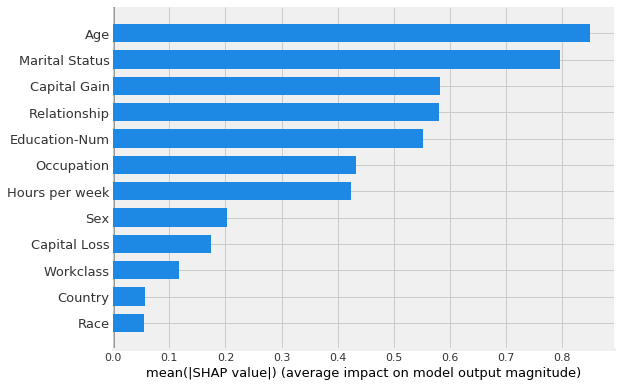

In [47]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

<h3>SHAP Summary Plot</h3>
<p>
    Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the age and marital status feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age or marital status. In other words, capital gain effects a few predictions by a large amount, while age or marital status effects all predictions by a smaller amount.
    <br><br>
    Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.</p>

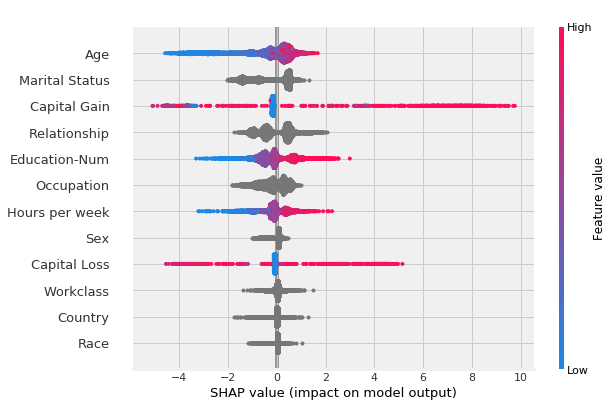

In [48]:
shap.summary_plot(shap_values, X_test_modelInterpretation)

<h3>SHAP Dependence Plots</h3>
<p>
    SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.
    <br><br>
    It can be notice its similarity with Skater's Partial Dependence Plots!
    <h3>PDP of 'Age' affecting Model Prediction</h3>
    <br>
    Just like it is observed before, the middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people.
</p>

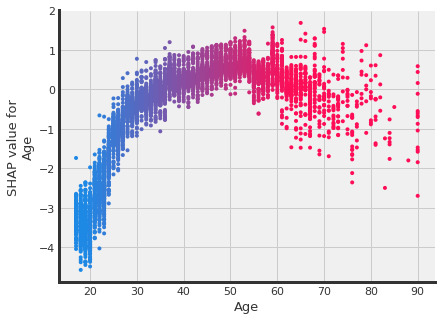

In [49]:
shap.dependence_plot(ind='Age',
                     interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_modelInterpretation)

<h3>PDP of 'Education-Num' affecting Model Prediction</h3>
<p>
    Higher education levels have higher shap values, pushing the model's prediction decissions to say that these individuals make more money as compared to people with lower education levels.
</p>

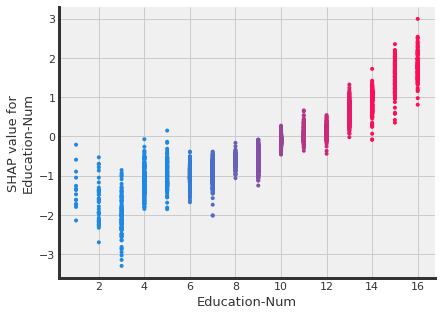

In [50]:
shap.dependence_plot(ind='Education-Num',
                     interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_modelInterpretation)

<h3>PDP of 'Relationship' affecting Model Prediction</h3>
<p>
    Just like it is observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to other folks.
</p>

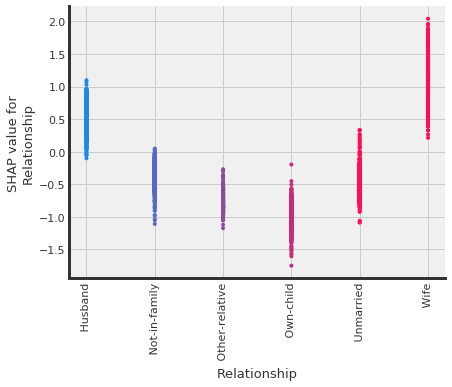

In [51]:
shap.dependence_plot(ind='Relationship',
                     interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_modelInterpretation)

<h3>PDP of 'Capital Gain' affecting Model Prediction</h3>
<p>
    It might have observed a very similar plot in the Skater PDPs, here typically a Capital Gain of more than \$5K - \$8K leads to a huge spike in the SHAP values making the model push towards prediction decisions to say that these individuals make more money as compared to others.</p>

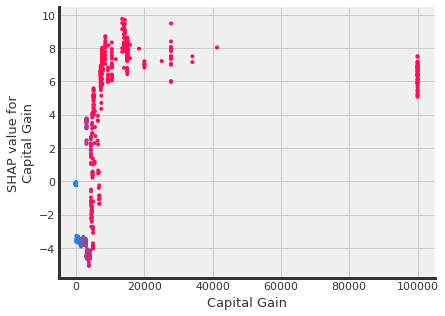

In [52]:
shap.dependence_plot(ind='Capital Gain',
                     interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_modelInterpretation)

<h3>Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than \$50K</h3>
<p>
    The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between <code>Age</code> and <code>Capital Gain</code> and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.
    <br><br>
    Interesting to see higher the higher capital gain and the middle-aged folks (30-50) having the highest chance of making more money!
</p>

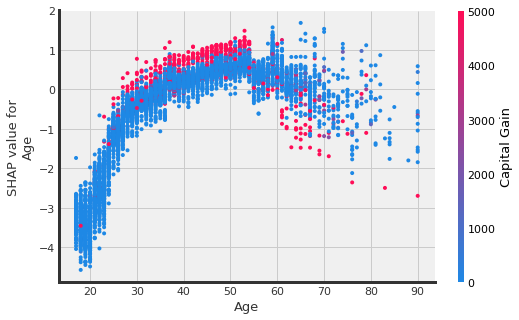

In [53]:
shap.dependence_plot(ind='Age',
                     interaction_index='Capital Gain',
                    shap_values=shap_values,
                    features=X_test,
                    display_features=X_test_modelInterpretation)

<h3>Two-way PDP showing interactions between features 'Education-Num' and 'Relationship' and their effect on making more than \$50K</h3>
<p>
    Interactions between <code>Education-Num</code> and <code>Relationship</code> and also effect on the SHAP values which lead to model predicting if the person will make more money or not, with the hel of a two-way partial dependence plot.
    <br><br>
    Interesting to see higher the higher education level and the husband or wife (married) folks having the highest chance of making more money.
</p>

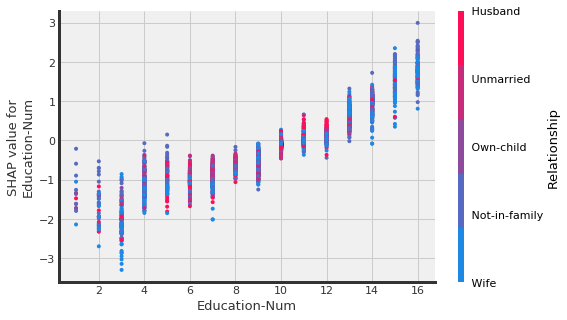

In [55]:
shap.dependence_plot(ind='Education-Num',
                    interaction_index='Relationship',
                    shap_values=shap_values,
                    features=X_test,
                    display_features=X_test_modelInterpretation)

<h3>Two-way PDP showing interactions between features 'Age' and 'Hours per Week' and their effect on making more than \$50K</h3>
<p>
    The interactions between <code>Age</code> and <code>Hours per week</code> and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.
    <br><br>
    Nothing extra-ordinary here, middle-aged people working the most make the most money!
</p>

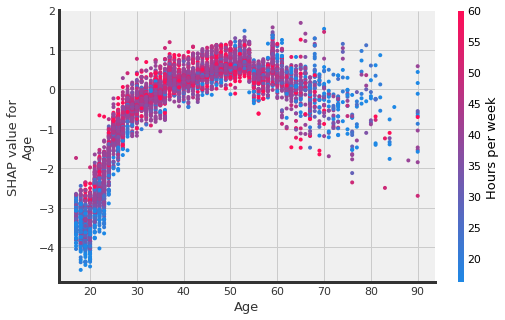

In [56]:
shap.dependence_plot(ind='Age',
                    interaction_index='Hours per week',
                    shap_values=shap_values,
                    features=X_test,
                    display_features=X_test_modelInterpretation)

<h2>Conclusions</h2>
<p>
    As has been demostrated there are several ways in which the predictions of a model can be interpretated, but usually it is better to use those frameworks, libraries that work with agnostic models, this because they try to explain in general way. 
</p>